In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as spi
import scipy.interpolate as spip

#Parameters

m = 0
#mass of the particle in GeV
alpha = 0.1
Mp = 2.435*(10**18) #reduced planck mass in GeV
eps = 10**(-3)
t0 = 0 #initial time
GeV_in_g     = 1.782661907e-24
r0 = 10**7
#Framework

def mesh_r(start, stop, num):
    return(np.linspace(start,stop, num))

def time(t0, tmax, n):
    return(np.linspace(t0,tmax, n))

#Functions

def tau(M0):
    return ((M0)**3)/(3*eps*(Mp**4))

def MBH(M0, t):
    tau_BH = tau(M0)
    return(M0*((1-(t-t0)/tau_BH)**(1/3))*np.heaviside(tau_BH-(t-t0), 0))
    

    
def Th(M0, t):
    return(1.06*((10**13/GeV_in_g)/(MBH(M0,t)))) #to change later
    #return(10)

def phi(M0, t):
    return(-(eps/Th(M0,t))*(Mp**4)/(MBH(M0, t)**2))  
    
def Temp(T0, r):
    Tinf = T0[T0.size - 1]
    r_adj = np.concatenate((r, np.linspace(r[-1], 100*r[-1], 100)))
    T_adj = np.concatenate((T0, Tinf*np.ones(100)))
    return((spip.interp1d(r, T0))) 


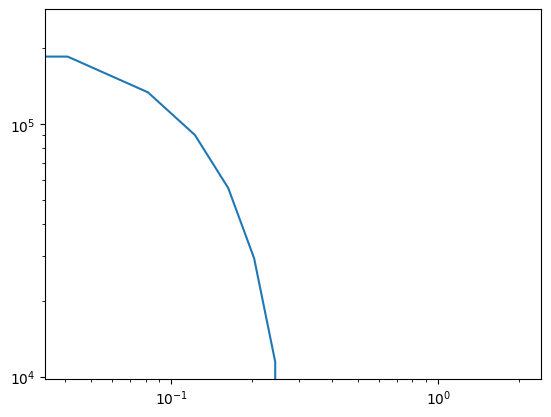

In [32]:
def g(Tem):
    return(10) #to change later 



def E(mesh, t, T0, M0):
    T = Temp(T0, mesh)
    #plt.plot(mesh, T(mesh))
    def dEdr(r, E):
        return((-r0*alpha**2)*np.sqrt(((T(r)**3)*E)/(1-m**2/E**2)))
    def stopping_event(r, v):
        return v[0]-max([T(r),1e-2*Th(M0,t)]) # Function to stop the solver if the Energy is equal or smaller than the plasma temperature
    stopping = lambda r, v:stopping_event(r, v)
    stopping.terminal  = True
    stopping.direction = -1
    y0 = np.array([Th(M0,t)])
    sol = spi.solve_ivp(dEdr,[mesh[0],mesh[-1]], y0, 'DOP853', events=[stopping], atol=1e-28, rtol=1e-13)
    #print('r thermalisation =', sol.t[-1])
    #print('(E)/T =', (sol.y[0][-1])/T(sol.t[-1]))
    #print('E =', (sol.y[0][-1]))
    if(sol.t[-1]<mesh[-1]):
        r_res = np.concatenate((sol.t,np.linspace(1.000001*sol.t[-1],mesh[-1],100)))
        E_res = np.concatenate((sol.y[0],np.zeros(100)))
        dEdr_res = np.concatenate(((-alpha**2)*np.sqrt(((T(sol.t)**3)*sol.y[0])/(1-m**2/sol.y[0]**2)),np.zeros(100)))
    else:
        print('reached maximum radius')
        r_res = sol.t
        E_res = sol.y[0]
        dEdr_res = (-r0*alpha**2)*np.sqrt(((T(sol.t)**3)*sol.y[0])/(1-m**2/sol.y[0]**2))
   # print(sol.t, sol.y)
#     tt = np.reshape(sol.t, (sol.t).size)
    E_fun = spip.interp1d(r_res,E_res)
    dEdr_fun = spip.interp1d(r_res,dEdr_res)
#     plt.semilogy(sol.t,sol.y[0])
#     plt.semilogy(sol.t,sol.y[1])
#     plt.semilogy(mesh,T0)
#     plt.xlim([sol.t[0],sol.t[-1]])
#     plt.show()
#     print(sol.t[-1])
#     print(mesh[-1])
#     E_vec = np.vectorize(E_fun)
#     dEdr_vec = np.vectorize(dEdr_fun)
    E_tab = E_fun(mesh)
    dEdr_tab = dEdr_fun(mesh)
    return [E_tab,dEdr_tab]


T_in = 10**(-1) 
M_in = 10**13*Mp
t_in = 0
t_fin = tau(M_in)

   
#test
num =50 #number of points in the mesh
mesh = mesh_r(0, 2,num)
T_mesh = T_in *np.ones(len(mesh))


E1, dE1 = E(mesh,t_in, T_mesh, M_in)
plt.loglog(mesh,E1)
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_27160\1536968250.py:10: RuntimeWarning: invalid value encountered in sqrt
  return((-r0*alpha**2)*np.sqrt(((T(r)**3)*E)/(1-m**2/E**2)))


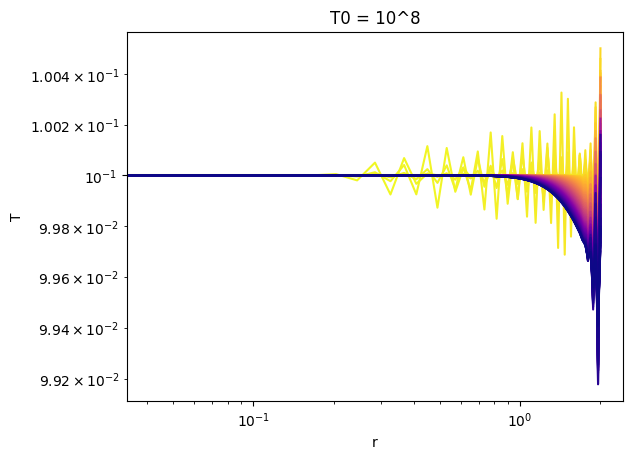

In [33]:
def Te_r(T0, time0, mesh, M0):
    num = mesh.size
    if T0.size != num :
        raise Exception('The size of T0 should be num.')
    else :
        r = mesh
        def dTdt(t, T):
            dTdr = np.zeros(num) #we impose periodic boundary conditions 
            dTdr2 = np.zeros(num)
            dTdr2[0] = (T[1]-2*T[0]+T[num-1])/((r[1]-r[0])**2)
            dTdr[1:num-1] = (T[2:num]-T[0:num-2])/(r[2:num]-r[0:num-2])
            dTdr2[1:num-1] = (T[2:num]-2*T[1:num-1]+T[0:num-2])/(((r[2:num]-r[0:num-2])/2)**2)
            dTdr[0] = 0
            dTdr[num-1] = 0
            dTdr2[num-1] = (2*T[num-2]-2*T[num-1])/((r[num-1]-r[num-2])**2)
            E0, dE0dr = E(r, t, T, M0)
            #print(E0.size, T.size)
            #T_m = np.amin(T0)
            #y0 = np.array([Th(t)])
            #t_th = 1/((alpha**2)*T_m*np.sqrt(2*T_m/y0))
            #if t < t_th:
            #print(t)
        #print(((T(r)**3),((E+m)**3)),((E**2)+m*E), (-alpha**2)*np.sqrt(((T(r)**3)*((E+m)**3))/((E**2)+m*E))*(1-(m/(E+m))**2)**2)
        #print(E, m)
            #return(((45/(((np.pi*alpha)**2)*T*g(T)))*dTdr +
                  # (45*(r**2)/(((np.pi*alpha*T)**2)*g(T)))*(dTdr)**2 +
                  # (30*(r**2)/(((np.pi*alpha)**2)*T*g(T)))*dTdr2 + 
                  # ((15*phi(M01,t)/(8*((np.pi*T)**3)*g(T)))*dE0dr #enlever le terme si E =0
                  #  )))
            return( (1/(((np.pi*alpha)**2)*T*g(T)))*
                   ((45/r0)*dTdr +
                   (r**2)*
                   ((45/T)*(dTdr**2)
                   + 30*dTdr2)) +
                   ((15*phi(M0,t)/(8*r0*((np.pi*T)**3)*g(T)))*dE0dr)
                    )
            #else:
               # return(((45/(((np.pi*alpha)**2)*T*g(T)))*dTdr +
                 #  (45*(r**2)/(((np.pi*alpha*T)**2)*g(T)))*(dTdr)**2 +
                   #(30*(r**2)/(((np.pi*alpha)**2)*T*g(T)))*dTdr2))
        sol = spi.solve_ivp(dTdt, [time0[0], time0[time0.size -1]], T0, 'RK45')
        #print('hello')
        res = [sol.y, sol.t]
        return(res)
    
#def T_ref()

tmax = 0.001
n= 2
time01 = time(t0, tmax, n)


plt.xlabel('r')
plt.ylabel('T')


[T1, duration] = Te_r(T_mesh, time01, mesh, M_in)
colors = plt.cm.plasma_r(np.linspace(0,1,num=duration.size))
T1_loc = np.transpose(T1)
for i in range(duration.size):
    plt.plot(mesh, T1_loc[i], color = colors[i])

rdecin = 3*10**-10*(alpha/0.1)**(-8/5)*(g(T_in)/106.75)**(1/5)*(g(Th(M_in,0))/108)**(-4/5)*(Th(M_in, 0)/8.62 * 10**-14*10**4)**(-11/5)
rdec = 3*10**-10*(alpha/0.1)**(-8/5)*(g(T_in)/106.75)**(1/5)*(g(Th(M_in,tmax))/108)**(-4/5)*(Th(M_in, tmax)/8.62 * 10**-14*10**4)**(-11/5)

rcrin = 6*10**7*(alpha/0.1)**-6*(g(T_in)/106.75)**(-2/3)*(g(Th(M_in,0))/108)**-1*Th(M_in, 0)**-1

#plt.axvline(rdecin, color ='r' , label = 'r_dec(M_in)')
#plt.axvline(rdec, color = 'y', label = 'r_dec(M)')
#plt.axvline(rcrin, label = 'r_cr(M_in)')
#print(rdec)
#print(rdecin)
#plt.axvline
#plt.legend()
plt.title('T0 = 10^8')
plt.yscale('log')
plt.xscale('log')

